TypeName         0
Inches           0
Ram              0
Weight           0
Price            0
screen_x         0
screen_y         0
IPS              0
touchscreen      0
Cpu_brand        0
Cpu_speed_GHz    0
SSD              0
HDD              0
Gpu_brand        0
os               0
apple            0
dtype: int64
R-squared: 0.8273086331985514
Mean Squared Error: 57951940.91318442

Feature Importance (Linear Regression):
                    Feature    Coefficient  Abs_Coefficient
2                    Weight -150408.991639    150408.991639
0                    Inches   40506.867413     40506.867413
7             Cpu_speed_GHz   21836.830418     21836.830418
16          Gpu_brand_Intel   17066.419255     17066.419255
15            Gpu_brand_AMD  -17066.419255     17066.419255
5                       IPS   -7053.311291      7053.311291
1                       Ram    6733.624894      6733.624894
12  Cpu_brand_Intel Core i5   -1648.657178      1648.657178
13  Cpu_brand_Intel Core i7     84

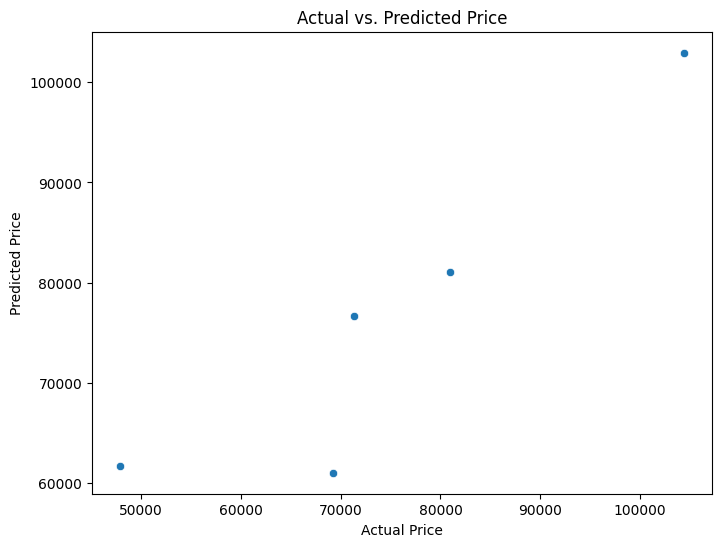

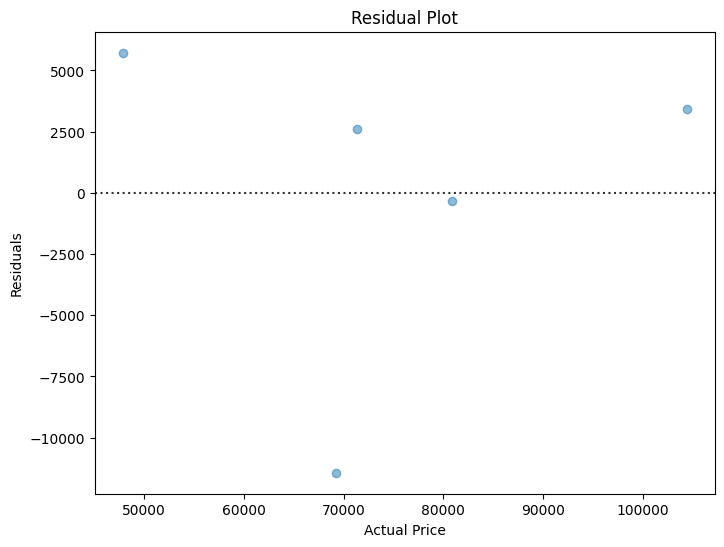

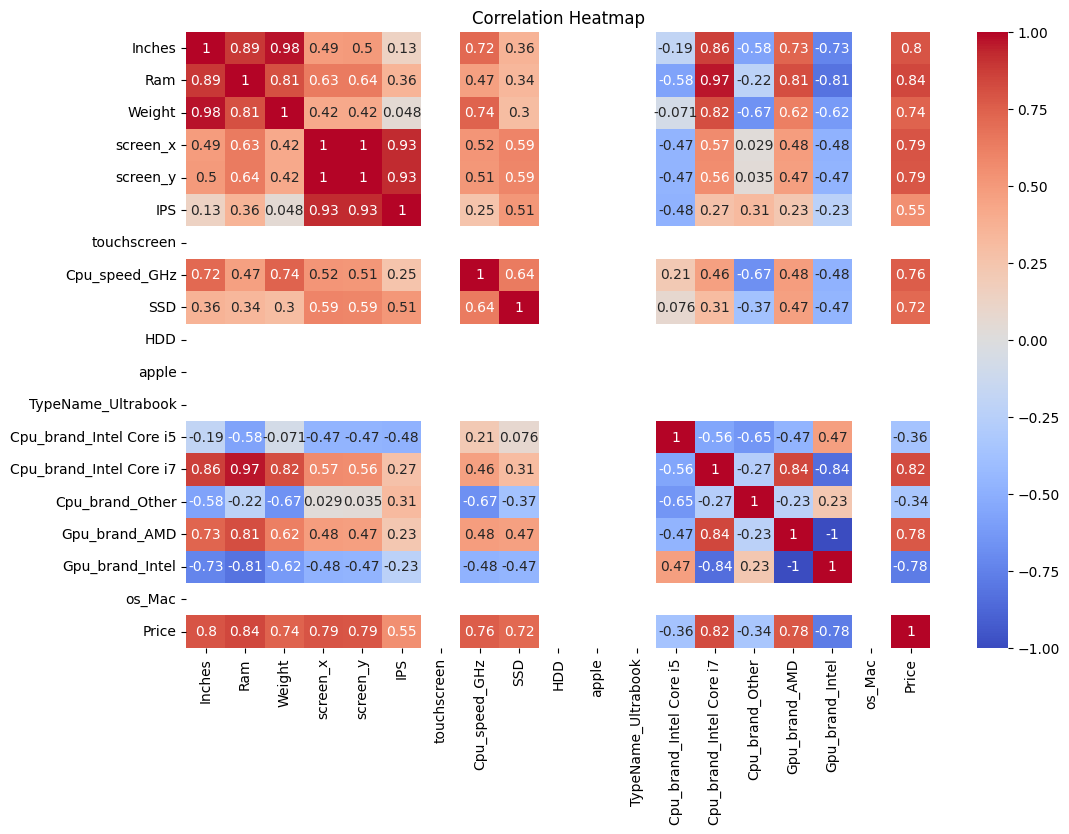

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns  # For enhanced visualizations

df = pd.read_csv('laptop_data.csv')

# --- Data Cleaning and Feature Engineering ---

# 1. Ram
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)

# 2. Weight
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

# 3. Price
df['Price'] = df['Price'].astype(float)

# 4. Screen Resolution
resolution_x = []
resolution_y = []

for i in df['ScreenResolution']:
    try:
        x, y = i.split(' ')[-1].split('x')
        resolution_x.append(int(x))
        resolution_y.append(int(y))
    except ValueError:
        # Handle cases where the resolution format might be different
        resolution_x.append(0)  # Or a more appropriate default like NaN
        resolution_y.append(0)

df['screen_x'] = resolution_x
df['screen_y'] = resolution_y

df['IPS'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)
df['touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)

# 5. CPU
df['Cpu_name'] = df['Cpu'].apply(lambda x: " ".join(x.split()[0:3]))

def process_cpu(name):
    if 'Intel Core i7' in name:
        return 'Intel Core i7'
    elif 'Intel Core i5' in name:
        return 'Intel Core i5'
    elif 'Intel Core i3' in name:
        return 'Intel Core i3'
    elif 'AMD' in name:
        return 'AMD'
    else:
        return 'Other'

df['Cpu_brand'] = df['Cpu_name'].apply(process_cpu)
df['Cpu_speed_GHz'] = df['Cpu'].str.extract(r'(\d+\.\d+|\d+)GHz').astype(float)  # Extract GHz

# 6. Memory
df['Memory'] = df['Memory'].astype(str).str.replace(r'\.0', '', regex=True)
df['Memory'] = df['Memory'].str.replace('GB', '', regex=False)
df['Memory'] = df['Memory'].str.replace('TB', '000', regex=False)

new = df['Memory'].str.split(',', n=1, expand=True)

df['first'] = new[0]
df['first_SSD'] = df['first'].apply(lambda x: 1 if 'SSD' in x else 0)
df['first_HDD'] = df['first'].apply(lambda x: 1 if 'HDD' in x else 0)
df['first'] = df['first'].str.extract(r'(\d+)')

df['second'] = new[1].fillna('0') if new.shape[1] > 1 else '0'

df['Second_SSD'] = df['second'].apply(lambda x: 1 if 'SSD' in x else 0)
df['Second_HDD'] = df['second'].apply(lambda x: 1 if 'HDD' in x else 0)
df['second'] = df['second'].str.extract(r'(\d+)')

df['first'] = pd.to_numeric(df['first'], errors='coerce').fillna(0).astype(int)
df['second'] = pd.to_numeric(df['second'], errors='coerce').fillna(0).astype(int)

df['SSD'] = df['first_SSD'] * df['first'] + df['Second_SSD'] * df['second']
df['HDD'] = df['first_HDD'] * df['first'] + df['Second_HDD'] * df['second']

df.drop(columns=['first', 'second', 'first_SSD', 'first_HDD', 'Second_SSD', 'Second_HDD'], inplace=True)

# 7. GPU
df['Gpu_brand'] = df['Gpu'].apply(lambda x: x.split()[0])
df.drop(columns=['Gpu'], inplace=True)
df = df[df['Gpu_brand'] != 'ARM']

# 8. OS
def cat_os(inp):
    if inp in ['Windows 10', 'Windows 7', 'Windows 10 S']:
        return 'Windows'
    elif inp in ['macOS', 'Mac OS X']:
        return 'Mac'
    else:
        return 'Other/No OS/Linux'

df['os'] = df['OpSys'].apply(cat_os)

# 9. Apple (Company)
df['apple'] = df['Company'].apply(lambda x: 1 if 'Apple' in x else 0)
df.drop(columns=['Company'], inplace=True)
df = df[df['apple'] == 1] #Keep only Apple laptops

# Drop Unnecessary Columns
df.drop(columns=['Unnamed: 0', 'ScreenResolution', 'Cpu', 'Cpu_name', 'OpSys', 'Memory'], inplace=True)

# --- Model Training ---

# Handle Missing Values (NaN)
print(df.isnull().sum())  # Check for missing values
df.dropna(inplace=True)  # Simplest way: Drop rows with NaNs.  Consider imputation for better results

X = df.drop(columns=['Price'])
y = df['Price']

X = pd.get_dummies(X, columns=['TypeName', 'Cpu_brand', 'Gpu_brand', 'os'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")

# Feature Importance
if isinstance(model, LinearRegression):
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
    print("\nFeature Importance (Linear Regression):")
    print(feature_importance.head(10))

# --- Visualization ---


plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Price')
plt.show()

# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.5})
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Correlation Heatmap
# Create a DataFrame with the numerical features (X after one-hot encoding) and the target variable (y)
correlation_df = pd.concat([X, y], axis=1)
corr_matrix = correlation_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()